<a href="https://colab.research.google.com/github/daniasawalha/deep-learning-project-skin-classificaion-/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan  1 23:42:05 2024

@author: Dania
"""

from __future__ import print_function, division
import torch
from torchvision import transforms, models
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import skimage
from skimage import io
import warnings
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler
import time
import copy
from torchvision.models import resnet50
import sys
from sklearn.model_selection import train_test_split, KFold
from torchvision import models
import multiprocessing
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
from torchvision.models import resnet18, mobilenet_v3_small, densenet121

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#multiprocessing.set_start_method('spawn', True)
warnings.filterwarnings("ignore")

# Define the ensemble prediction function
def ensemble_predictions(models, dataloader, device):
    all_predictions = []

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs = batch["image"].to(device)
            outputs = torch.zeros((len(models), len(inputs))).to(device)

            # Aggregate predictions from each model
            for j, model in enumerate(models):
                outputs[j] = model(inputs.float()).argmax(dim=1)

            # Use simple majority voting
            ensemble_preds = outputs.mode(dim=0).values
            ensemble_preds = ensemble_preds.long().cpu().numpy().tolist() if ensemble_preds.numel() > 1 else [ensemble_preds.item()]  # Ensure predictions are integers
            all_predictions.extend(ensemble_preds)

    return all_predictions



def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])


def train_model(label, dataloaders, device, dataset_sizes, model,
                criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    training_results = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')  # Initialize with a very high value

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for batch in dataloaders[phase]:
                inputs = batch["image"].to(device)
                labels = batch[label].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    inputs = inputs.float()
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save results to training_results
            training_results.append({
                'phase': phase,
                'epoch': epoch,
                'loss': epoch_loss,
                'accuracy': epoch_acc
            })

            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                scheduler.step(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    training_results_df = pd.DataFrame(training_results)
    return model, training_results_df


class SkinDataset():
    def __init__(self, csv_file, root_dir, transform=None, limit_per_label=100):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            limit_per_label (int): Maximum number of images to read per label.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.limit_per_label = limit_per_label
        self.label_count = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.df.loc[self.df.index[idx], 'hasher'] + '.jpg')

        if os.path.exists(img_name):
            hasher = self.df.loc[self.df.index[idx], 'hasher']

            # Check if we reached the limit for the current label
            if hasher not in self.label_count:
                self.label_count[hasher] = 0
            if self.label_count[hasher] >= self.limit_per_label:
                return None  # Skip this sample

            # Update the count for the current label
            self.label_count[hasher] += 1

            image = io.imread(img_name)
            if len(image.shape) < 3:
                image = skimage.color.gray2rgb(image)

            high = self.df.loc[self.df.index[idx], 'high']
            mid = self.df.loc[self.df.index[idx], 'mid']
            low = self.df.loc[self.df.index[idx], 'low']
            fitzpatrick = self.df.loc[self.df.index[idx], 'fitzpatrick_scale']

            if self.transform:
                image = self.transform(image)

            sample = {
                'image': image,
                'high': high,
                'mid': mid,
                'low': low,
                'hasher': hasher,
                'fitzpatrick': fitzpatrick
            }

            return sample
        else:
            # Handle the case where the image file does not exist
            return None  # Or raise an exception


def custom_load(
    batch_size=256,
    num_workers=4,
    train_dir='',
    val_dir='',
    image_dir='/content/gdrive/MyDrive/all'
):
    val = pd.read_csv(val_dir)
    train = pd.read_csv(train_dir)

    class_sample_count = np.array(train[label].value_counts().sort_index())
    weight = 1. / np.sqrt(class_sample_count)
    samples_weight = np.array([weight[t] for t in train[label]])
    samples_weight = torch.from_numpy(samples_weight)

    # Create a WeightedRandomSampler for training data
    sampler = WeightedRandomSampler(
        samples_weight.type('torch.DoubleTensor'),
        len(samples_weight),
        replacement=True
    )

    dataset_sizes = {"train": train.shape[0], "val": val.shape[0]}
    transformed_train = SkinDataset(
        csv_file=train_dir,
        root_dir=image_dir,
        transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(size=256, scale=(0.3, 1.0)),
            transforms.RandomRotation(degrees=30),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),

            transforms.RandomAffine(degrees=50, translate=(0.3, 0.1)),
            transforms.CenterCrop(size=256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    )

    transformed_test = SkinDataset(
        csv_file=val_dir,
        root_dir=image_dir,
        transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=256),
            transforms.CenterCrop(size=256),

            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )

    dataloaders = {
        "train": torch.utils.data.DataLoader(
            transformed_train,
            batch_size=batch_size,
            sampler=sampler,
            num_workers=num_workers
        ),
        "val": torch.utils.data.DataLoader(
            transformed_test,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )
    }

    return dataloaders, dataset_sizes


if __name__ == '__main__':
    # In the custom_load() function, make sure to specify the path to the images
    print("\nPlease specify number of epochs and 'dev' mode or not... e.g. python train.py 10 full \n")
    n_epochs = 30
    dev_mode = 'full'
    print("CUDA is available: {} \n".format(torch.cuda.is_available()))
    print("Starting... \n")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if dev_mode == "dev":
        df = pd.read_csv("/content/gdrive/MyDrive/fitzpatrick17k_updated.csv").sample(1000)
    else:
        df = pd.read_csv("/content/gdrive/MyDrive/fitzpatrick17k_updated.csv")
    print(df['fitzpatrick_scale'].value_counts())
    print("Rows: {}".format(df.shape[0]))
    df["low"] = df['label'].astype('category').cat.codes
    df["mid"] = df['nine_partition_label'].astype('category').cat.codes
    df["high"] = df['three_partition_label'].astype('category').cat.codes
    df["hasher"] = df["md5hash"]

    for holdout_set in ["random_holdout"]:
        if holdout_set == "random_holdout":
            train, test, y_train, y_test = train_test_split(
                                                df,
                                                df.low,
                                                test_size=0.25,
                                                random_state=0,
                                                stratify=df.low)


            print(test.shape)
            print(test.shape)
        data_dir = "/content/gdrive/My Drive/path_to_dataset"
        os.makedirs(data_dir, exist_ok=True)
        train_path = os.path.join(data_dir, "temp_train.csv")
        test_path = os.path.join(data_dir, "temp_test.csv")

        print("Training Shape: {}, Test Shape: {} \n".format(
        train.shape,
        test.shape)
        )
        for indexer, label in enumerate(["low"]):
            print(label)
            weights = np.array(max(train[label].value_counts())/train[label].value_counts().sort_index())
            label_codes = sorted(list(train[label].unique()))
            dataloaders, dataset_sizes = custom_load(
                256,
                4,
                "{}".format(train_path),
                "{}".format(test_path))
            # Train and aggregate predictions using bagging
            num_bagging_models = 2  # Adjust as needed
            bagging_models = []

            for i in range(num_bagging_models):
               print(f"Training Bagging Model {i + 1}...")
               dataloaders, dataset_sizes = custom_load(
                   256, 4, "{}".format(train_path), "{}".format(test_path))

            model_ft = resnet50(pretrained=True)
            for param in model_ft.parameters():
                param.requires_grad = False
            in_features = model_ft.fc.in_features
            model_ft.fc = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.PReLU(),
                nn.BatchNorm1d(512),
                nn.Linear(512, 1024),
                nn.PReLU(),
                nn.BatchNorm1d(1024),
                nn.Dropout(0.3),
                nn.PReLU(),
                nn.Linear(1024, len(label_codes)),
                nn.LogSoftmax(dim=0)
            )

            total_params = sum(p.numel() for p in model_ft.parameters())
            print('{} total parameters'.format(total_params))
            total_trainable_params = sum(
                p.numel() for p in model_ft.parameters() if p.requires_grad)
            print('{} total trainable parameters'.format(total_trainable_params))
            model_ft = model_ft.to(device)
            model_ft = nn.DataParallel(model_ft)
            class_weights = torch.FloatTensor(weights).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer_ft = optim.Adamax(model_ft.parameters(), lr=0.001, weight_decay=0.2)
            exp_lr_scheduler = ReduceLROnPlateau(
                optimizer_ft,
                mode='max',
                factor=0.1,
                patience=10,
                verbose=True
            )





           # Calculate accuracy



            print("\nTraining classifier for {}........ \n".format(label))
            print("....... processing ........ \n")
            model_ft, training_results = train_model(
                label,
                dataloaders, device,
                dataset_sizes, model_ft,
                criterion, optimizer_ft,
                exp_lr_scheduler, n_epochs)

            bagging_models.append(model_ft)

               # Make predictions on the validation set
            ensemble_predictions_list = ensemble_predictions(bagging_models, dataloaders['val'], device)

               # Combine bagging predictions
            final_predictions = [Counter([int(predictions)]).most_common(1)[0][0] for predictions in ensemble_predictions_list]
            correct_predictions = sum(final_predictions == dataloaders['val'].dataset.df[label])
            total_samples = len(dataloaders['val'].dataset)

            accuracy = correct_predictions / total_samples
            print(f"Ensemble Accuracy: {accuracy}")
            print("Training Complete")
            torch.save(model_ft.state_dict(), "model_path_{}_{}_{}.pth".format(n_epochs, label, holdout_set))
            print("gold")

            training_results.to_csv("training_{}_{}_{}.csv".format(n_epochs, label, holdout_set), index=False)
            model = model_ft.eval()
            loader = dataloaders["val"]
            prediction_list = []
            fitzpatrick_list = []
            hasher_list = []
            labels_list = []
            p_list = []
            topk_p = []
            topk_n = []
            d1 = []
            d2 = []
            d3 = []
            p1 = []
            p2 = []
            p3 = []
            with torch.no_grad():
                running_corrects = 0
                for i, batch in enumerate(dataloaders['val']):
                    inputs = batch["image"].to(device)
                    classes = batch[label].to(device)
                    fitzpatrick = batch["fitzpatrick"]
                    hasher = batch["hasher"]
                    outputs = model(inputs.float())
                    probability = outputs
                    ppp, preds = torch.topk(probability, 1)
                    if label == "low":
                        _, preds5 = torch.topk(probability, 3)
                        topk_p.append(np.exp(_.cpu()).tolist())
                        topk_n.append(preds5.cpu().tolist())
                    running_corrects += torch.sum(preds == classes.data)
                    # Ensure preds is not a scalar before converting to list
                    preds_list = preds.cpu().tolist() if preds.numel() > 1 else [preds.item()]
                    p_list.append(ppp.cpu().tolist())
                    prediction_list.append(preds_list)
                    labels_list.append(classes.tolist())
                    fitzpatrick_list.append(fitzpatrick.tolist())
                    hasher_list.append(hasher)
                acc = float(running_corrects) / float(dataset_sizes['val'])
                print("running_corrects:",running_corrects)
                print("dataset_sizes['val']",dataset_sizes['val'])
            if label == "low":
                for j in topk_n:
                    for i in j:
                        d1.append(i[0])
                        d2.append(i[1])
                        d3.append(i[2])
                for j in topk_p:
                    for i in j:
                        print(i)
                        p1.append(i[0])
                        p2.append(i[1])
                        p3.append(i[2])
                df_x=pd.DataFrame({
                                    "hasher": flatten(hasher_list),
                                    "label": flatten(labels_list),
                                    "fitzpatrick": flatten(fitzpatrick_list),
                                    "prediction_probability": flatten(p_list),
                                    "prediction": flatten(prediction_list),
                                    "d1": d1,
                                    "d2": d2,
                                    "d3": d3,
                                    "p1": p1,
                                    "p2": p2,
                                    "p3": p3})
            else:

                df_x=pd.DataFrame({
                                    "hasher": flatten(hasher_list),
                                    "label": flatten(labels_list),
                                    "fitzpatrick": flatten(fitzpatrick_list),
                                    "prediction_probability": flatten(p_list),
                                    "prediction": flatten(prediction_list)})
            df_x.to_csv("results_{}_{}_{}.csv".format(n_epochs, label, holdout_set),
                            index=False)

        print("done")


Please specify number of epochs and 'dev' mode or not... e.g. python train.py 10 full 

CUDA is available: False 

Starting... 

fitzpatrick_scale
 4    265
 3    234
 5    206
 2    149
 6     58
-1     46
 1     29
Name: count, dtype: int64
Rows: 987
(247, 13)
(247, 13)
Training Shape: (740, 13), Test Shape: (247, 13) 

low
Training Bagging Model 1...
Training Bagging Model 2...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


25093707 total parameters
1585675 total trainable parameters

Training classifier for low........ 

....... processing ........ 

Epoch 0/29
----------
train Loss: 1.6342 Acc: 0.3946
val Loss: 1.9633 Acc: 0.5142
Epoch 1/29
----------
train Loss: 1.0152 Acc: 0.6797
val Loss: 1.9138 Acc: 0.6275
Epoch 2/29
----------
train Loss: 0.8574 Acc: 0.6892
val Loss: 1.8818 Acc: 0.6559
Epoch 3/29
----------
train Loss: 0.7664 Acc: 0.7514
val Loss: 1.8496 Acc: 0.6842
Epoch 4/29
----------
train Loss: 0.7462 Acc: 0.7365
val Loss: 1.8082 Acc: 0.7247
Epoch 5/29
----------
train Loss: 0.6299 Acc: 0.8000
val Loss: 1.7667 Acc: 0.7206
Epoch 6/29
----------
train Loss: 0.6520 Acc: 0.7649
val Loss: 1.7274 Acc: 0.7166
Epoch 7/29
----------
train Loss: 0.6325 Acc: 0.7892
val Loss: 1.6688 Acc: 0.7490
Epoch 8/29
----------
train Loss: 0.5992 Acc: 0.8095
val Loss: 1.5932 Acc: 0.7449
Epoch 9/29
----------
train Loss: 0.5717 Acc: 0.8149
val Loss: 1.5365 Acc: 0.7166
Epoch 10/29
----------
train Loss: 0.5862 Acc: 0.7

In [ ]:
from torchsummary import summary
summary(model_ft.module, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

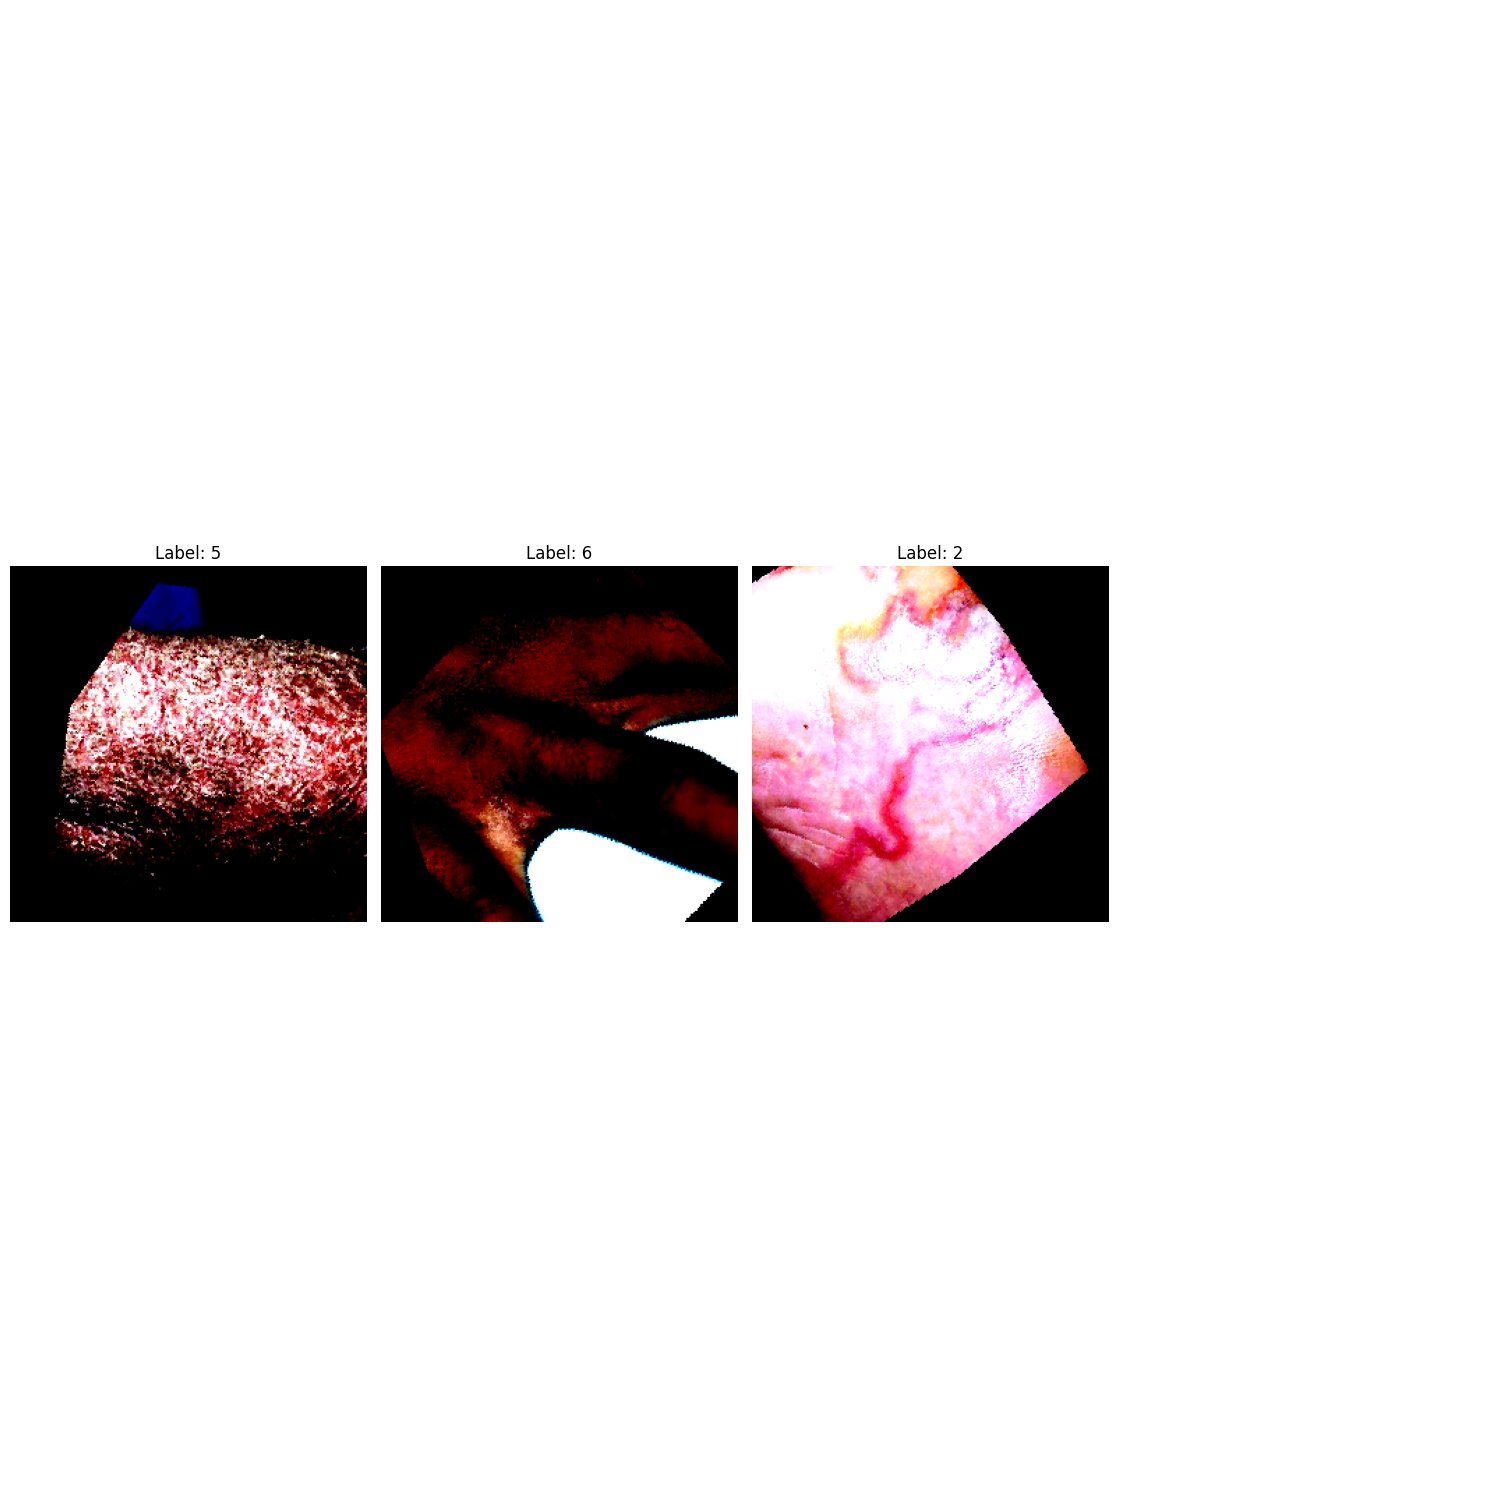

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display a grid of images
def show_images(images, labels, ncols=4):
    nrows = int(np.ceil(len(images) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define a function to sample images from the dataset
def sample_images(dataloader, n_samples=16):
    images = []
    labels = []
    for i, sample in enumerate(dataloader):
        if i >= n_samples:
            break
        images.append(sample['image'][0].permute(1, 2, 0).numpy())  # Convert tensor to numpy array and transpose dimensions
        labels.append(sample[label][0].item())
    return images, labels

# Call the sample_images function and display the sampled images
sampled_images, sampled_labels = sample_images(dataloaders['train'], n_samples=16)
show_images(sampled_images, sampled_labels)


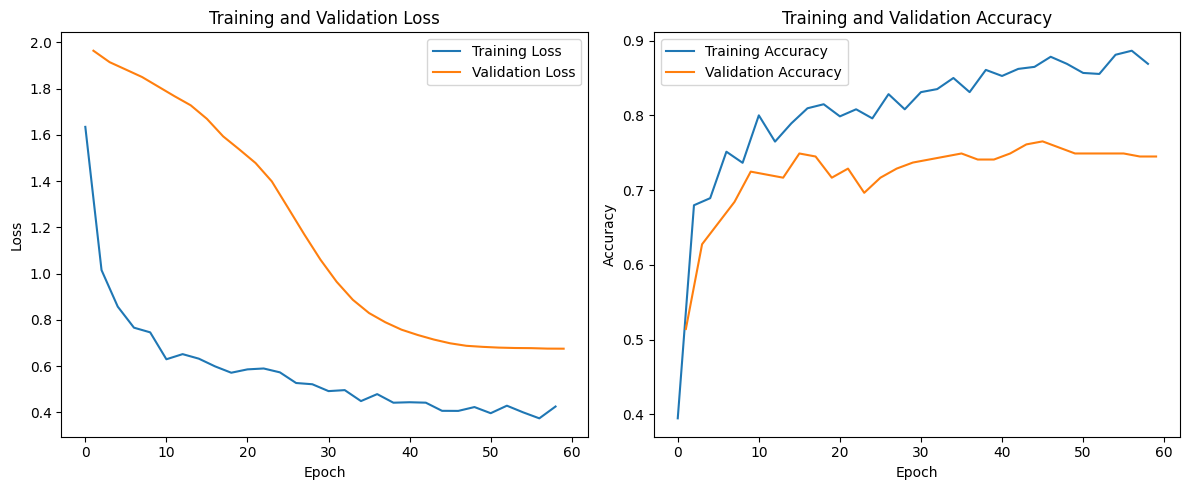

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the training results dataframe
train_loss = training_results[training_results['phase'] == 'train']['loss']
train_accuracy = training_results[training_results['phase'] == 'train']['accuracy']
val_loss = training_results[training_results['phase'] == 'val']['loss']
val_accuracy = training_results[training_results['phase'] == 'val']['accuracy']

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()